# HW06: One-Versus-All Support Vector Classification
## Hamza Dehidi KU 0077989
### December 15, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial.distance as dt
import cvxopt as cvx

## Importing Data

In [2]:
# read data into memory
X_data_set = np.genfromtxt("hw06_images.csv", delimiter = ",")
y_data_set = np.genfromtxt("hw06_labels.csv", delimiter = ",")

# x and y training values
X_train = X_data_set[:1000]
y_train = y_data_set[:1000].astype('int')

# x and y test values
X_test = X_data_set[1000:]
y_test = y_data_set[1000:].astype('int')

In [3]:
# get number of samples and number of features
N_train = len(y_train)
D_train = X_train.shape[1]


In [4]:
# number of labels
k = np.max(y_train)

## Distance and Kernel Functions

$\begin{equation}
    \begin{split}
        d(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= ||\boldsymbol{x}_{i} - \boldsymbol{x}_{j}||_{2} = \sqrt{(\boldsymbol{x}_{i} - \boldsymbol{x}_{j})^{\top} (\boldsymbol{x}_{i} - \boldsymbol{x}_{j})} = \sqrt{\sum\limits_{d = 1}^{D}(x_{id} - x_{jd})^{2}} \\
        k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= \exp\left(-\dfrac{||\boldsymbol{x}_{i} -\boldsymbol{x}_{j}||_{2}^{2}}{2s^{2}}\right)
    \end{split}
\end{equation}$

In [5]:
# define Gaussian kernel function
def gaussian_kernel(X1, X2, s=10):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

## Learning Algorithm

#### Primal Problem
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;& \dfrac{1}{2} ||\boldsymbol{w}||_{2}^{2} + C \sum\limits_{i = 1}^{N} \xi_{i} \\
		\mbox{with respect to}\;\;& \boldsymbol{w} \in \mathbb{R}^{D},\;\; \boldsymbol{\xi} \in \mathbb{R}^{N},\;\; w_{0} \in \mathbb{R} \\
		\mbox{subject to}\;\;& y_{i} (\boldsymbol{w}^{\top} \boldsymbol{x}_{i} + w_{0}) \geq 1 - \xi_{i} \;\;\;\; i = 1,2,\dots,N \\
		& \xi_{i} \geq 0\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem
$\begin{equation}
	\begin{split}
		\mbox{maximize}\;\;& \sum\limits_{i = 1}^{N} \alpha_{i} - \dfrac{1}{2} \sum\limits_{i = 1}^{N} \sum\limits_{j = 1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) \\
		\mbox{with respect to}\;\;& \boldsymbol{\alpha} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \sum\limits_{i = 1}^{N} \alpha_{i} y_{i} = 0 \\
		& 0 \leq \alpha_{i} \leq C\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem in Matrix-Vector Form
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;&-\boldsymbol{1}^{\top} \boldsymbol{\alpha} + \dfrac{1}{2} \boldsymbol{\alpha}^{\top} ((y y^{\top}) \odot \mathbf{K}) \boldsymbol{\alpha} \\
		\mbox{with respect to}\;\; & \boldsymbol{\alpha} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \boldsymbol{y}^{\top} \boldsymbol{\alpha} = 0 \\
		& \boldsymbol{0} \leq \boldsymbol{\alpha} \leq C \boldsymbol{1} \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

In [6]:
class SVM:
    
    def __init__(self):
        # create necessary data structures
        self.__y = list([])
        self.__alpha = list([])
        self.__w0 = list([])
        
              
    def fit(self, X, y, C=10, s=10):
        
        # calculate Gaussian kernel
        K_train = gaussian_kernel(X, X, s)
        yyK = np.matmul(y[:,None], y[None,:]) * K_train
       
        # set learning parameters
        epsilon = 1e-3

        P = cvx.matrix(yyK)
        q = cvx.matrix(-np.ones((N_train, 1)))
        G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
        h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
        A = cvx.matrix(1.0 * y[None,:])
        b = cvx.matrix(0.0)

        # use cvxopt library to solve QP problems
        result = cvx.solvers.qp(P, q, G, h, A, b)
        alpha = np.reshape(result["x"], N_train)
        alpha[alpha < C * epsilon] = 0
        alpha[alpha > C * (1 - epsilon)] = C

        # find bias parameter
        support_indices, = np.where(alpha != 0)
        active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
        w0 = np.mean(y[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))

        # calculate predictions on training samples
        f_predicted = np.matmul(K_train, y[:,None] * alpha[:,None]) + w0
        
        # append parameters to use them during test
        self.__y.append(y)
        self.__alpha.append(alpha)
        self.__w0.append(w0)

        return f_predicted
        
    
    def predict(self, X, c): 
        
        # choosing the parameters corresponding to the class
        y = self.__y[c]
        alpha = self.__alpha[c]
        w0 = self.__w0[c]

        return np.matmul(gaussian_kernel(X, X_train), y[:,None] * alpha[:,None]) + w0

In [7]:
model = SVM()

# function to to fit training data and return the predicted y values
def discriminant_train(X, C=10):
    scores = np.zeros((N_train, 0))
    for c in range (k):
        y_train_copy = -1*np.ones(N_train)
        y_train_copy[y_train == c+1] = 1    # copy of the traing labels where the current class is 1 and all others are -1
        f_predicted = model.fit(X_train, y_train_copy, C)
        scores = np.hstack((scores,f_predicted))
        y_predicted = np.argmax(scores, axis=1) + 1 # to choose the class corresponding to the maximum prediction
    
    return y_predicted 

In [8]:
# Calculate the confusion matrix for the data points in training set
confusion_matrix = pd.crosstab(discriminant_train(X_train), y_train, rownames = ['y_predicted'], colnames = ['y_train'])
print(confusion_matrix)

     pcost       dcost       gap    pres   dres
 0:  2.9600e+01 -4.2260e+04  8e+04  4e-01  3e-14
 1:  1.2992e+01 -7.4611e+03  8e+03  2e-02  3e-14
 2: -6.2643e+02 -2.9089e+03  2e+03  4e-03  3e-14
 3: -8.9105e+02 -1.7204e+03  8e+02  1e-03  4e-14
 4: -1.0255e+03 -1.3482e+03  3e+02  2e-04  4e-14
 5: -1.0893e+03 -1.1778e+03  9e+01  2e-05  5e-14
 6: -1.1096e+03 -1.1353e+03  3e+01  3e-07  5e-14
 7: -1.1169e+03 -1.1209e+03  4e+00  5e-14  5e-14
 8: -1.1184e+03 -1.1185e+03  1e-01  6e-14  5e-14
 9: -1.1185e+03 -1.1185e+03  4e-03  1e-14  5e-14
10: -1.1185e+03 -1.1185e+03  7e-05  4e-14  5e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9161e+02 -4.0951e+04  8e+04  4e-01  3e-14
 1:  1.7375e+02 -7.6611e+03  9e+03  2e-02  3e-14
 2: -4.0615e+02 -2.9616e+03  3e+03  6e-03  3e-14
 3: -6.2557e+02 -1.7531e+03  1e+03  2e-03  4e-14
 4: -7.5417e+02 -1.1618e+03  4e+02  4e-04  4e-14
 5: -8.2696e+02 -9.7495e+02  1e+02  8e-14  5e-14
 6: -8.5262e+02 -8.9665e+02  4e+01  2e-14  4e-1

In [9]:
# function to to predict the test labels
def discriminant_test(X, C=10):
    scores = np.zeros((X_test.shape[0], 0))
    for c in range (k):
        predicted = model.predict(X, c)
        scores = np.hstack((scores,predicted))
        y_predicted = np.argmax(scores, axis=1) + 1 
    
    return y_predicted

In [10]:
# Calculate the confusion matrix for the data points in test set
confusion_matrix = pd.crosstab(discriminant_test(X_test), y_test, rownames = ['y_predicted'], colnames = ['y_test'])
print(confusion_matrix)

y_test         1    2    3    4    5
y_predicted                         
1            641   23    3  137    9
2             43  714   27   40    4
3              4   39  666   90   10
4            100   32   69  541   16
5             12    2    6   15  757


## Training Performance

In [11]:
C = np.logspace(-1, 3, num=5)

In [12]:
accuracy_train = []
accuracy_test = []

for c in C:
    model = SVM()
    
    y_predicted_train =  discriminant_train(X_train, C=c)
    confusion_matrix_train = pd.crosstab(y_predicted_train, y_train, rownames = ['y_predicted'], colnames = ['y_train'])
    accuracy_train.append(np.diag(confusion_matrix_train).sum() / confusion_matrix_train.to_numpy().sum())
    
    y_predicted_test =  discriminant_test(X_test, C=c)
    confusion_matrix_test = pd.crosstab(y_predicted_test, y_test, rownames = ['y_predicted'], colnames = ['y_test'])
    accuracy_test.append(np.diag(confusion_matrix_test).sum() / confusion_matrix_test.to_numpy().sum())
    

     pcost       dcost       gap    pres   dres
 0: -1.3936e+02 -2.2047e+02  7e+03  3e+01  3e-15
 1: -3.4801e+01 -2.0264e+02  4e+02  9e-01  3e-15
 2: -2.8151e+01 -7.9601e+01  5e+01  2e-15  3e-15
 3: -3.1266e+01 -4.3423e+01  1e+01  1e-15  2e-15
 4: -3.2572e+01 -3.9120e+01  7e+00  9e-16  2e-15
 5: -3.3423e+01 -3.6637e+01  3e+00  1e-15  1e-15
 6: -3.3666e+01 -3.6029e+01  2e+00  1e-15  1e-15
 7: -3.4121e+01 -3.4971e+01  9e-01  1e-15  1e-15
 8: -3.4319e+01 -3.4585e+01  3e-01  2e-15  2e-15
 9: -3.4415e+01 -3.4445e+01  3e-02  2e-15  2e-15
10: -3.4429e+01 -3.4430e+01  1e-03  2e-15  2e-15
11: -3.4429e+01 -3.4429e+01  5e-05  5e-16  2e-15
12: -3.4429e+01 -3.4429e+01  1e-06  5e-16  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1812e+02 -2.1835e+02  7e+03  3e+01  3e-15
 1: -3.1287e+01 -2.0015e+02  5e+02  1e+00  3e-15
 2: -2.4529e+01 -8.1514e+01  6e+01  2e-16  3e-15
 3: -2.7550e+01 -4.0807e+01  1e+01  2e-15  2e-15
 4: -2.8779e+01 -3.6453e+01  8e+00  4e-16  2e-1

 6: -1.0174e+03 -1.0749e+03  6e+01  1e-05  4e-14
 7: -1.0296e+03 -1.0480e+03  2e+01  8e-14  4e-14
 8: -1.0350e+03 -1.0380e+03  3e+00  8e-14  4e-14
 9: -1.0360e+03 -1.0362e+03  2e-01  1e-14  4e-14
10: -1.0361e+03 -1.0361e+03  4e-03  2e-14  4e-14
11: -1.0361e+03 -1.0361e+03  7e-05  9e-14  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.0057e+02 -5.0242e+04  8e+04  3e-01  5e-14
 1: -5.5603e+02 -8.9813e+03  9e+03  1e-02  6e-14
 2: -1.3487e+03 -3.4368e+03  2e+03  2e-03  6e-14
 3: -1.6731e+03 -2.5433e+03  9e+02  3e-04  6e-14
 4: -1.8026e+03 -2.1922e+03  4e+02  6e-05  6e-14
 5: -1.8680e+03 -1.9850e+03  1e+02  8e-06  7e-14
 6: -1.8927e+03 -1.9224e+03  3e+01  7e-07  7e-14
 7: -1.9008e+03 -1.9050e+03  4e+00  1e-13  8e-14
 8: -1.9023e+03 -1.9024e+03  1e-01  3e-14  7e-14
 9: -1.9023e+03 -1.9023e+03  2e-03  5e-14  7e-14
10: -1.9023e+03 -1.9023e+03  5e-05  2e-13  7e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.0372e+02 -3.9006

13: -1.6180e+03 -1.6250e+03  7e+00  4e-14  2e-13
14: -1.6203e+03 -1.6207e+03  4e-01  3e-13  2e-13
15: -1.6204e+03 -1.6204e+03  5e-03  8e-15  2e-13
16: -1.6204e+03 -1.6204e+03  9e-05  2e-13  2e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6092e+07 -3.6559e+08  5e+08  2e-01  4e-12
 1:  1.1537e+07 -6.1870e+07  8e+07  2e-02  2e-11
 2:  4.8978e+06 -1.8971e+07  2e+07  6e-03  7e-12
 3:  1.7138e+06 -6.8321e+06  9e+06  7e-04  4e-12
 4:  5.3680e+05 -2.3698e+06  3e+06  2e-13  4e-12
 5:  2.3023e+05 -1.0554e+06  1e+06  1e-12  2e-12
 6:  9.0450e+04 -4.3818e+05  5e+05  3e-12  2e-12
 7:  1.1082e+04 -3.9758e+04  5e+04  2e-12  1e-12
 8: -9.7930e+02 -8.9481e+03  8e+03  1e-13  5e-13
 9: -2.5200e+03 -5.3745e+03  3e+03  5e-14  4e-13
10: -3.1184e+03 -4.0057e+03  9e+02  2e-13  3e-13
11: -3.3092e+03 -3.5607e+03  3e+02  7e-13  3e-13
12: -3.3664e+03 -3.4192e+03  5e+01  6e-13  3e-13
13: -3.3810e+03 -3.3857e+03  5e+00  3e-13  3e-13
14: -3.3824e+03 -3.3826e+03  1e-01  4e-15  3e-

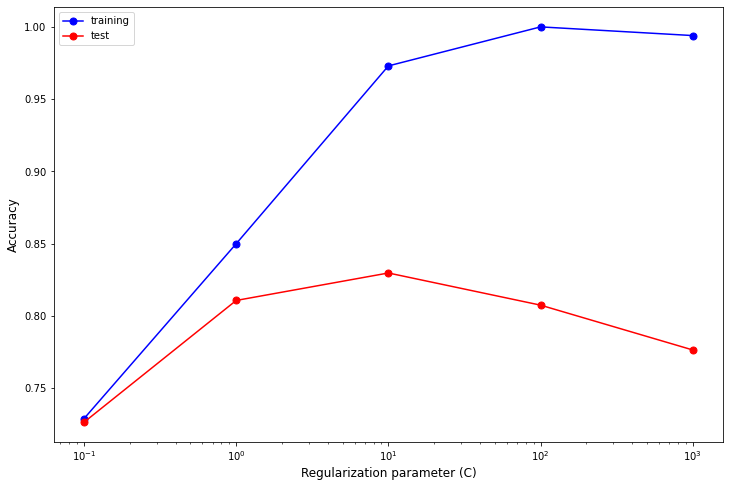

In [13]:
plt.figure(figsize = (12, 8))
plt.plot(C,accuracy_train, "-bo",markersize = 7,label ='training')
plt.plot(C,accuracy_test, "-ro", markersize = 7,label ='test')
plt.legend()
plt.xlabel('Regularization parameter (C)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xscale('log')
plt.show()